# Classical Shadows

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/goodchemistryco/Tangelo/blob/develop/examples/classical_shadows.ipynb)

The output of a quantum computer is a histogram of measurements, corresponding to the different outcomes observed, usually expressed as bitstrings. The cost and duration of a quantum experiment is roughly linear with the number of shots used to build such histograms, which also correlates with the accuracy of the results. This measurement overhead can be prohibitive for state tomography and computation of observables for quantum chemistry applications.

The emergent method *classical shadows* ([Nat. Phys. 2020, 16, 1050–1057](https://arxiv.org/abs/2002.08953)) has been developed to mitigate the measurement overhead by offloading quantum tasks to the pre- and post-processing steps. This prediction protocol exhibits logarithmic scaling with the number of terms to measure, in order to compute the expectation value of a term within a given accuracy.

In short, gates representing a unitary operation are appended to the state prepared by a quantum circuit. Upon measurement, the output bitstring (ex: 100101...) is stored in a conventional register. This is repeated $N$ times, where $N$ defines the shadow size and is equivalent to the number of shots run on the quantum hardware. The classical shadow is built from the bitstrings stored in the classical register, and can be used to calculate observables. Different flavours of classical shadow exist, as they each come with a specific protocol for choosing a set of unitaries. The figure below, from [Nat. Phys. 16, 1050–1057 (2020)](https://arxiv.org/abs/2002.08953), illustrates the randomized shadow protocol.

![Classical Shadows overview](img/classical_shadow_overview.png "Classical Shadow")

The randomized, derandomized and adaptive shadow protocols using the single-qubit Pauli basis as a set of unitaries  are currently available in Tangelo. This introduction will shed light on how to leverage their use in your own investigation, and highlight the main differences between these approaches. At the end of this notebook, a comparison is made between energies predicted with those techniques and the one computed by using a Hamiltonian partitioning approach relying on qubitwise commutativity.

This notebook assumes that you already have installed Tangelo in your Python environment, or have updated your Python path so that the imports can be resolved. If not, executing the cell below installs the minimal requirements for this notebook.

In [1]:
# Installation of tangelo if not already installed.
try:
    import tangelo
except ModuleNotFoundError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

## System and Reference Values
To demonstrate the classical shadow capabilities, we first define a molecular system composed of two hydrogen atoms in the 3-21G basis. After using the scBK qubit mapping, the Hamiltonian spans 6 qubits.

In [2]:
from tangelo.molecule_library import mol_H2_321g
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits

# Encoding options.
encoding = "scBK"
up_then_down = True

# Converting the fermionic Hamiltonian according to the encoding options.
qubit_ham = fermion_to_qubit_mapping(mol_H2_321g.fermionic_hamiltonian, 
                                     encoding, 
                                     n_spinorbitals=mol_H2_321g.n_active_sos, 
                                     n_electrons=mol_H2_321g.n_active_electrons, 
                                     up_then_down=up_then_down)

print(f"Number of qubits to describe the system: {count_qubits(qubit_ham)}")

Number of qubits to describe the system: 6


For this example, the Qubit Coupled-Cluster (QCC) ansatz has been chosen ([J. Chem. Theory Comput. 2018, 14(12), 6317–6326](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00932)). While the circuit depth rapidly increases with the size of the basis (number of spin orbitals), the QCC ansatz admits a low-depth quantum circuit compared to the widely used Unitary Coupled-Cluster Single and Double (UCCSD) ansatz.

In [3]:
from tangelo.toolboxes.ansatz_generator.qcc import QCC

ansatz = QCC(mol_H2_321g, mapping=encoding, up_then_down=up_then_down)
ansatz.build_circuit()

print(f"Number of gates in the circuit: {ansatz.circuit.size}")

Number of gates in the circuit: 79


The Variational Quantum Eigensolver (VQE) has been introduced in another notebook as a hybrid quantum–classical algorithm for simulating quantum systems. In the next cell, we focus on VQE within the context of optimizing the QCC variational parameters to minimize the 3-21G dihydrogen energy.

In [4]:
from tangelo.algorithms.variational import VQESolver

vqe = VQESolver({"qubit_hamiltonian": qubit_ham, "ansatz": ansatz.circuit})
vqe.build()
energy_ref = vqe.simulate()
print(f"Energy from statevector simulation: {energy_ref:.4f} hartree")

Energy from statevector simulation: -1.1473 hartree


Now, we can get the optimized circuit with the `vqe.optimal_circuit` attribute, and we also know that with the provided Hamiltonian, the ideal energy is -1.1475 hartree.

## Classical Shadows
In this section, we will revisit the computation of the 3-21G dihydrogen energy using the QCC ansatz and the classical shadow protocols. Three flavours of classical shadows are currently available in Tangelo. Each flavour has a distinct class: `RandomizedClassicalShadow`, `DerandomizedClassicalShadow` and `AdaptiveClassicalShadow`. Common methods `build` and `simulate` are defined to respectively construct a set of unitaries and simulate results with a given backend. As a side note, a user who wants to compare noisy simulation can do so by providing the appropriate `noise_model` to the `Simulator` object defined in the next cell.

In [5]:
from tangelo.linq import get_backend, Circuit

# Definition of the shots budget (shadow size) and backend.
n_shots_budget = 1000
backend = get_backend("cirq", noise_model=None)

### Randomized Single-Qubit Pauli Classical Shadows
Randomized classical shadows are the orginal implementation of this algorithm. Random bases are constructed from the tensor product of random single-qubit Pauli gates ($X$, $Y$ or $Z$). The post-processing consists of inverting the samples with the quantum channel $\mathcal{M}^{-1} = \bigotimes_{i=1}^n \mathcal{M}_i^{-1}$. Observables can then be predicted from the median of means. More details can be found in [Nat. Phys. 16, 1050–1057 (2020)](https://arxiv.org/abs/2002.08953).

In [6]:
from tangelo.toolboxes.measurements import RandomizedClassicalShadow

random_cs = RandomizedClassicalShadow(vqe.optimal_circuit)
random_cs.build(n_shots_budget)
random_cs.simulate(backend)

energy_random = random_cs.get_observable(qubit_ham)
print(f"Energy from randomized single-Pauli classical shadow: {energy_random:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_random):.3f} hartree")

Energy from randomized single-Pauli classical shadow: -1.0593 hartree
Error vs statevector simulation: 0.088 hartree


### Derandomized Single-Qubit Pauli Classical Shadows
The derandomized procedure aims to fix a drawback of the randomized procedure. As the number of qubits increases, the probability of matching random tensor products of single-Pauli bases with terms in a qubit Hamiltonian decreases greatly. Typically, bigger shadows are needed to compute an observable within a reasonable accuracy. The derandomized procedure takes as input a qubit operator to steer the basis choices, thus removing the randomness. This results in bases hitting the relevant operator systematically, improving the accuracy for a given shadow size versus a randomized classical shadow. More details on this algorithm can be found in [Phys. Rev. Lett. 127, 030503](https://arxiv.org/abs/2103.07510).

In [7]:
from tangelo.toolboxes.measurements import DerandomizedClassicalShadow

derandom_cs = DerandomizedClassicalShadow(vqe.optimal_circuit)
derandom_cs.build(n_shots_budget, qubit_ham)
derandom_cs.simulate(backend)

energy_derandom = derandom_cs.get_observable(qubit_ham)
print(f"Energy from derandomized single-Pauli classical shadow: {energy_derandom:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_derandom):.3f} hartree")

Energy from derandomized single-Pauli classical shadow: -1.1765 hartree
Error vs statevector simulation: 0.029 hartree


### Adaptive Single-Qubit Pauli Classical Shadows
Another procedure for choosing single-qubit Pauli bases is an adaptive one. It uses an iterative process to draw a Pauli gate for each qubit, one by one. The probability distributions are built so the next single-qubit Pauli gates drawn will depend on the measurement bases already assigned to previous qubits. This shifts the single-qubit Pauli basis choice towards terms hitting a given operator, while keeping a fair amount of randomness to extent the state characterization coverage. For more details on this algorithm, we refer to [arXiv:2105.12207](https://arxiv.org/abs/2105.12207).

In [8]:
from tangelo.toolboxes.measurements import AdaptiveClassicalShadow

adaptive_cs = AdaptiveClassicalShadow(vqe.optimal_circuit)
adaptive_cs.build(n_shots_budget, qubit_ham)
adaptive_cs.simulate(backend)

energy_adaptive = adaptive_cs.get_observable(qubit_ham)
print(f"Energy from adaptive single-Pauli classical shadow: {energy_adaptive:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_adaptive):.3f} hartree")

Energy from adaptive single-Pauli classical shadow: -1.3384 hartree
Error vs statevector simulation: 0.191 hartree


## Energy with Hamiltonian Partitioning
For a given measurement budget, we compare the accuracy of total energy computation obtained with the Hamiltonian partitioning approach relying on qubitwise commutativity, to the energy predicted by classical shadow protocols. The `group_qwc` method defines the minimal number of bases to measure by identifying commutating terms. Then, the number of shots can be evenly distributed or according to a heuristic that considers the term coefficients.

The reference value computed in the next cell only contains statistical errors and no quantum noise, 
even though it is always present in hardware. This shot-based simulation culminates with an energy containing an  error $\epsilon$, inherent to the finite numbers of measurements. This error $\epsilon$ will be compared to the ones coming from classical shadow protocols.

In [9]:
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.measurements import group_qwc, exp_value_from_measurement_bases
from tangelo.linq import Circuit
from tangelo.linq.helpers import measurement_basis_gates

# Performing Hamiltonian partitioning.
qubitwise_measurements = group_qwc(qubit_ham)

# Distributing the available number of shots evenly across identified bases.
n_shots_per_basis = round(n_shots_budget / len(qubitwise_measurements))

# Shot-based backend.
backend = get_backend("cirq", n_shots=n_shots_per_basis, noise_model=None)

# Computing the histograms for the grouped bases.
qubitwise_results = dict()
for basis in qubitwise_measurements.keys():
    basis_circuit = Circuit(measurement_basis_gates(basis))
    qubitwise_results[basis], _ = backend.simulate(vqe.optimal_circuit + basis_circuit)

# Computing the energy from the histograms.
energy_shots = exp_value_from_measurement_bases(qubitwise_measurements, qubitwise_results)

print(f"Energy with qubitwise commutativity and equally distributed shots: {energy_shots:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_shots):.3f} hartree")

Energy with qubitwise commutativity and equally distributed shots: -1.3012 hartree
Error vs statevector simulation: 0.154 hartree


## Averages of 10 runs
Due to the nature of the classical shadow processes, there is a random component during prediction of observables. This is why your mileage may vary if you try to rerun all code cells in this notebook. To better portray the situation, we preran 10 simulations of 10 000 shots each for all the above methods, and compared the results to the ideal energy obtained with VQE run with an exact statevector simulator. The data is shown in the boxplot below and the ideal energy is represented by a dashed line.

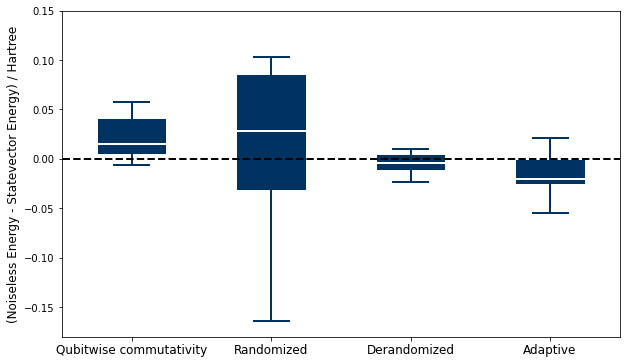

In [10]:
import matplotlib.pyplot as plt
import numpy as np

data = np.array([
    [ 0.00508,  0.02309, -0.03742, -0.02013],
    [ 0.01601, -0.16360, -0.02321, -0.02002],
    [ 0.04252,  0.03412,  0.00546, -0.05518],
    [ 0.01322,  0.10274,  0.00458,  0.02129],
    [ 0.05665, -0.01826, -0.00687, -0.01218],
    [ 0.05709, -0.08834, -0.01307,  0.00555],
    [-0.00185,  0.07029,  0.00910, -0.02183],
    [ 0.03663,  0.09825, -0.00555,  0.00459],
    [-0.00593,  0.09175, -0.00332, -0.04029],
    [ 0.00574, -0.03616,  0.00986, -0.02638]
])

_, ax = plt.subplots(figsize=(10,6))
VP = ax.boxplot(data, positions=[2, 4, 6, 8], 
                widths=1, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 2},
                boxprops={"facecolor": "#003262", "edgecolor": "white", "linewidth": 1},
                whiskerprops={"color": "#003262", "linewidth": 2},
                capprops={"color": "#003262", "linewidth": 2})

ax.set(ylim=(-.18, .15), xlim=(1, 9))
ax.hlines(y=0., xmin=0, xmax=10, linewidth=2, color="k", linestyles="dashed")

ax.set_xticklabels(labels=["Qubitwise commutativity", "Randomized", "Derandomized", "Adaptive"],fontsize=12)
ax.set_ylabel(r"(Noiseless Energy - Statevector Energy) / Hartree", fontsize=12)
plt.show()

For this use case, the plot shows that the derandomized and adaptive single-qubit Pauli classical shadows seem to be more accurate than the other methods. However, it is not clear whether randomized classical shadows are more appealing than qubitwise commutativity. From those results, the scaling advantage is not apparent at first sight, at least for this system (H2 3-21G).

Classical shadows may show benefits for larger problems, requiring many more qubit terms to be evaluated. Several studies have taken a look at the noise implication of predicting observables with shadows ([arXiv:2011.09636](https://arxiv.org/abs/2011.09636) and [arXiv:2011.11580](https://arxiv.org/abs/2011.11580)). The authors demonstrate noise resilience inherent to classical shadows, especially when comparing to simpler sampling methods.

## Closing words
We demonstrated the use of several classical shadow protocols in this notebook. As their theoretical scaling is logarithmic with the number of linear functions in a qubit operator, they show potential for helping mitigate the measurement problem. Using Tangelo, we showed how straightforward it is to incorporate classical shadows in your own research projects. 

Many avenues have yet to be explored. For example, active research areas include implementation of classical shadows on NISQ devices, and some works report an inherent noise resilience ([arXiv:2011.11580](https://arxiv.org/abs/2011.11580)). What will you do with classical shadows and Tangelo ?

## References
1. Chen, S., Yu, W., Zeng, P. & Flammia, S. T. Robust shadow estimation. arXiv:2011.09636 [quant-ph] (2020).
2. Koh, D. E. & Grewal, S. Classical Shadows with Noise. arXiv:2011.11580 [math-ph, physics:quant-ph] (2020).
3. Huang, H.-Y., Kueng, R. & Preskill, J. Efficient estimation of Pauli observables by derandomization. arXiv:2103.07510 [quant-ph] (2021).
4. Hadfield, C. Adaptive Pauli Shadows for Energy Estimation. arXiv:2105.12207 [quant-ph] (2021).
5. Huang, H. Y., Kueng, R. & Preskill, J. Predicting many properties of a quantum system from very few measurements. Nature Physics 16, 1050–1057 (2020).